In [169]:
import numpy as np
import math
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms
import torch.nn as nn
from IPython.display import clear_output

# Task 1: maximum likelihood fit (3 points)

Let's generate a Gaussian mixture dataset and then fit its parameters with maximum likelihood.

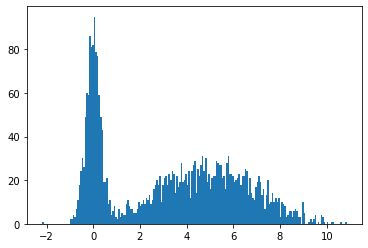

In [207]:
X1 = np.random.normal(size=1000, scale=0.3).astype('float32')
X2 = np.random.normal(size=2000, loc=5., scale=2.).astype('float32')

X = np.concatenate([X1, X2])
np.random.shuffle(X)

plt.hist(X, bins=200);

**Task**:
 - fill the gaps below to perform the max. likelihood fit with the pdf:
$$\text{PDF}(x|\mu_1, \sigma^2_1, \mu_2, \sigma^2_2, \alpha)
= \alpha\cdot\mathscr{N}(x|\mu_1, \sigma_1^2) + (1 - \alpha)\cdot\mathscr{N}(x|\mu_2, \sigma_2^2)$$
 - what the fitted values of $\mu_1, \sigma^2_1, \mu_2, \sigma^2_2$ and $\alpha$ should be? does your fit converge to them?

In [230]:
# Defining Gaussian PDF using torch functions
def gaussian(x, mu, sigma):
    # use torch.exp for the exponent, don't forget the normalization
    normalizer = 1 / math.sqrt(2 * math.pi * sigma)
    return normalizer * torch.exp(-0.5 * (x - mu)**2 / sigma)
  

# Arbitrary mixture PDF
def mixture(x, f1, f2, alpha):
    return alpha * f1(x) + (1. - alpha) * f2(x)

# Parameters that we'd like to infer (with an initial guess)
m1    = torch.tensor([1.0], requires_grad=True)
m2    = torch.tensor([4.0], requires_grad=True)
s1    = torch.tensor([1.0], requires_grad=True)
s2    = torch.tensor([0.1], requires_grad=True)
alpha = torch.tensor([0.5], requires_grad=True)

variables = [m1, m2, s1, s2, alpha]

# Defining the overall PDF
def model_pdf(x):
    return mixture(x,
                   lambda t: gaussian(t, m1, s1),
                   lambda t: gaussian(t, m2, s2),
                   alpha)

# Log likelihood
def loglike(x):
    return -torch.sum(torch.log(model_pdf(x)))

learning_rate = 0.000001
grad_history = [] # to keep track of gradient values at different steps



# At each gradient update we'll apply this function to
# ensure valid parameter values
def apply_constraints():
    # ensure the sigmas are positive (greater or equal to some small
    # positive number, e.g. 1e-5) and alpha is in (0, 1) interval
    # hint: use the `assign` method to update the variable values
    m1_grad = m1.grad.data
    m2_grad = m2.grad.data
    s1_grad = s1.grad.data
    s2_grad = s2.grad.data
    alpha_grad = alpha.grad.data
    m1.data = m1.data - learning_rate * m1_grad
    m2.data = m2.data - learning_rate * m2_grad
    s1.data = torch.max(s1.data - learning_rate * s1_grad, torch.tensor([1e-5]))
    s2.data = torch.max(s2.data - learning_rate * s2_grad, torch.tensor([1e-5]))
    alpha.data = torch.clamp(alpha.data - learning_rate * alpha_grad, 0, 1)
    
    grad_history.append((m1_grad.item(), m2_grad.item(), s1_grad.item(), s2_grad.item(), alpha_grad.item()))
    
    m1.grad.data.zero_()
    m2.grad.data.zero_()
    s1.grad.data.zero_()
    s2.grad.data.zero_()
    alpha.grad.data.zero_()

data = torch.tensor(X)

for i in range(1000):
    # Forward pass:
    loss = loglike(data)
    loss.backward()

    # Backprop
    # Gradient ascent step
    apply_constraints()

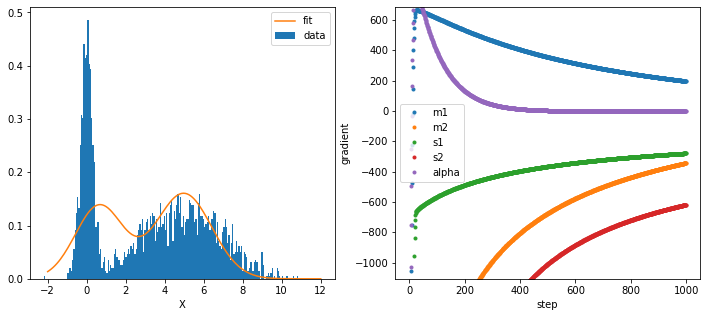

In [231]:
############################
# Do some plotting
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(X, bins=200, density=True, label='data')
x_grid = np.linspace(-2, 12, 150)
plt.plot(x_grid, model_pdf(torch.tensor(x_grid)).detach().numpy(), label='fit')
plt.legend()
plt.xlabel('X')

grad_history = torch.tensor(grad_history).detach().numpy()
plt.subplot(1, 2, 2)
lines = plt.plot(grad_history, '.')
low = min(grad_history[-1])
high = max(grad_history[-1])
plt.ylim(low  - (high - low) * 0.6,
          high + (high - low) * 0.6)
plt.legend(lines, ['m1', 'm2', 's1', 's2', 'alpha'])
plt.xlabel('step')
plt.ylabel('gradient')
plt.show()
clear_output(wait=True);